# Dynamics for Aircraft Mission Performance

So, what we've demonstrated so far is great for problems where we care about the nitty-gritty of what's happening - we are directly simulating all flight dynamics modes.

For the quadcopter doing a flip, this is a good thing! The vehicle's dynamics have characteristic times that are on the same timescale as the maneuvers of interest, so we should just go ahead and simulate everything.

However, this is overly complex for most aircraft design problems. Most missions of interest are on the order of hours long, while most aircraft flight dynamics modes are on the order of seconds.

We can therefore make some simplifying assumptions:

* The vehicle's short-period modes are negligible, and all modes that don't affect the vehicle energy management (i.e., performance) can be discarded. (On an airplane with classical flight dynamics modes, this would mean that we would ignore all modes other than the phugoid mode.)
* This implies that the angular rates $p$, $q$, and $r$ are zero.
* All lateral modes can be ignored, as we assume that $\beta, \phi, p, r=0$.
* Because the short-period longitudinal mode is negligible and $q=0$, we assume $\theta$ can be prescribed - so $\theta$ is now a control variable, not a state variable.
* Our remaining state variables are $x_e, z_e, u, w$. We can re-parameterize this as $x_e, z_e, V, \gamma$ (where $V$ is the airspeed and $\gamma$ is the flight path angle) to reduce coupling.

Here, we can show what that looks like in practice.

## Optimal Gliding Problem

Let's say you're my Ph.D. advisor, John Hansman, and you're flying over central Massachusetts in your Cessna 152. All of a sudden, you hear your engine start to sputter - oh no.

In [1]:
thrust = 0

Let's determine:

1. Can he make it back to the airport?
2. What's the most energy-optimal trajectory to fly?

### Performance Estimation

To start, let's roughly define a vehicle geometry here, which we'll then use to estimate vehicle performance. (Both Geometry and Aerodynamics are covered in later tutorial sections.)

#### Geometry Reconstruction

Geometry is roughly given by this three-view:

![threeview](./assets/cessna150.gif)

Which we can represent as:

In [2]:
import aerosandbox as asb
import aerosandbox.numpy as np
from aerosandbox.tools import units as u

from cessna152 import airplane  # See cessna152.py for details.

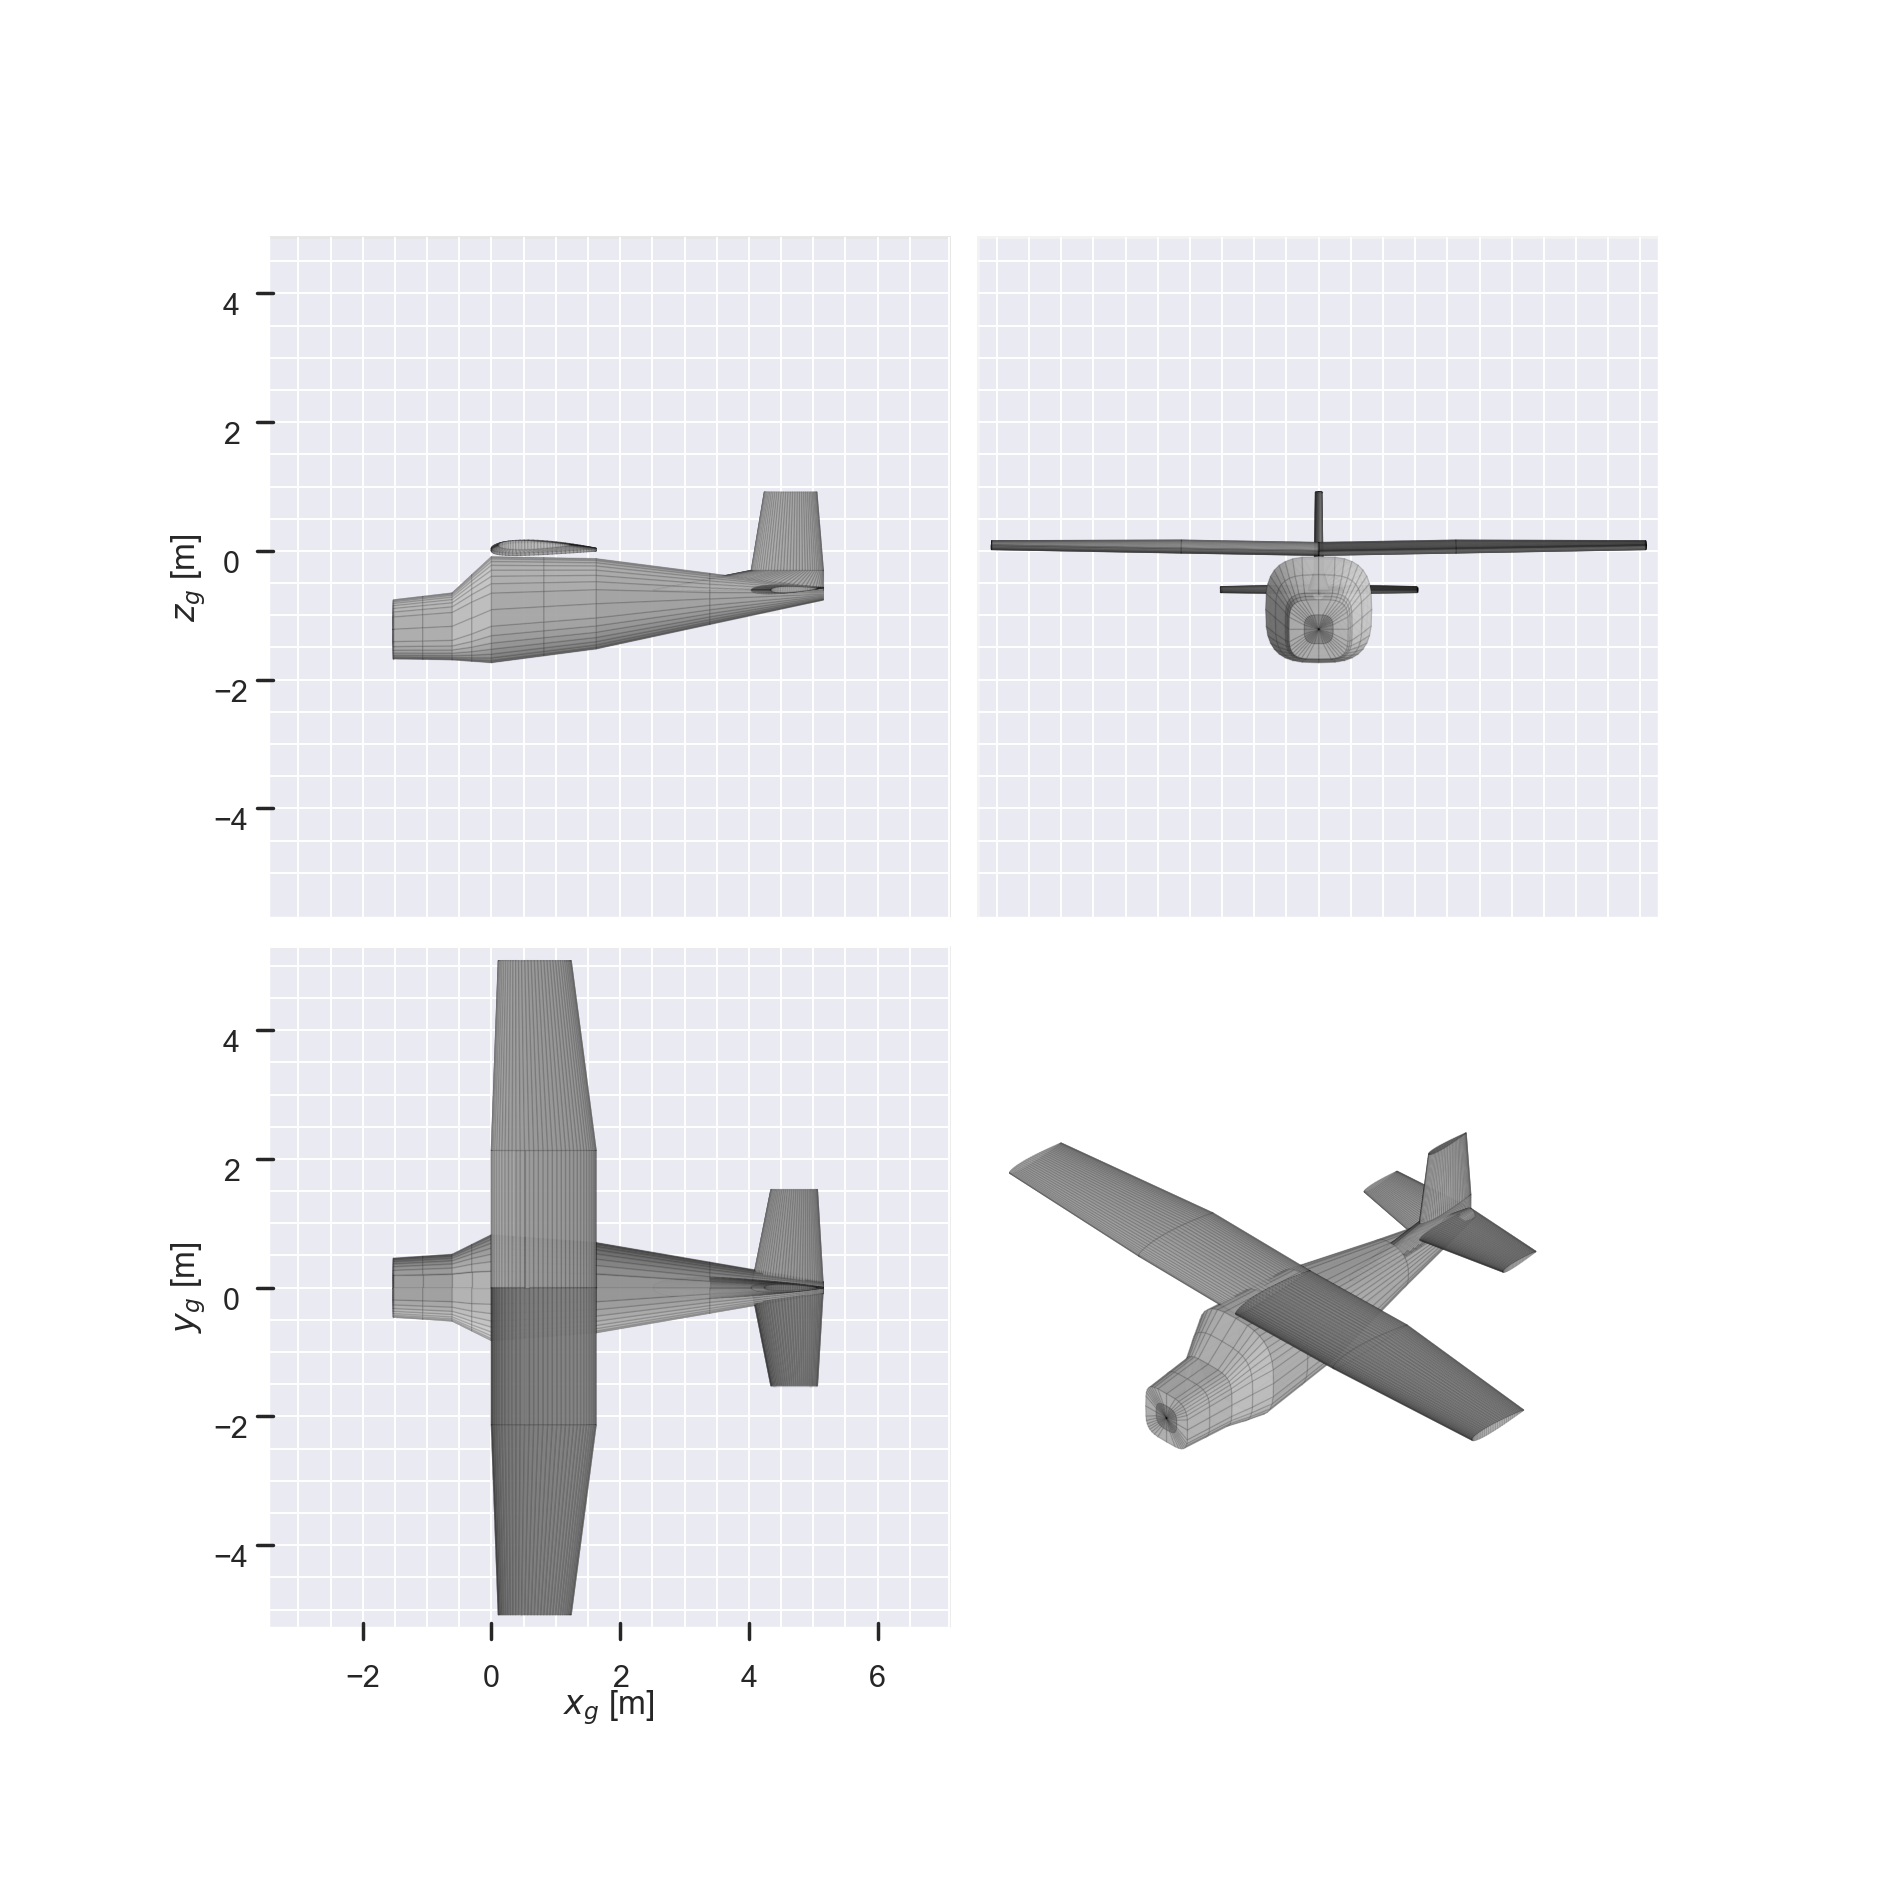

In [3]:
airplane.draw_three_view()

#### Aerodynamic Performance Estimation

We can then use our geometry to estimate polars using AeroSandbox's `AeroBuildup` engine. Details are described in later tutorials; for now, we just focus on the results:

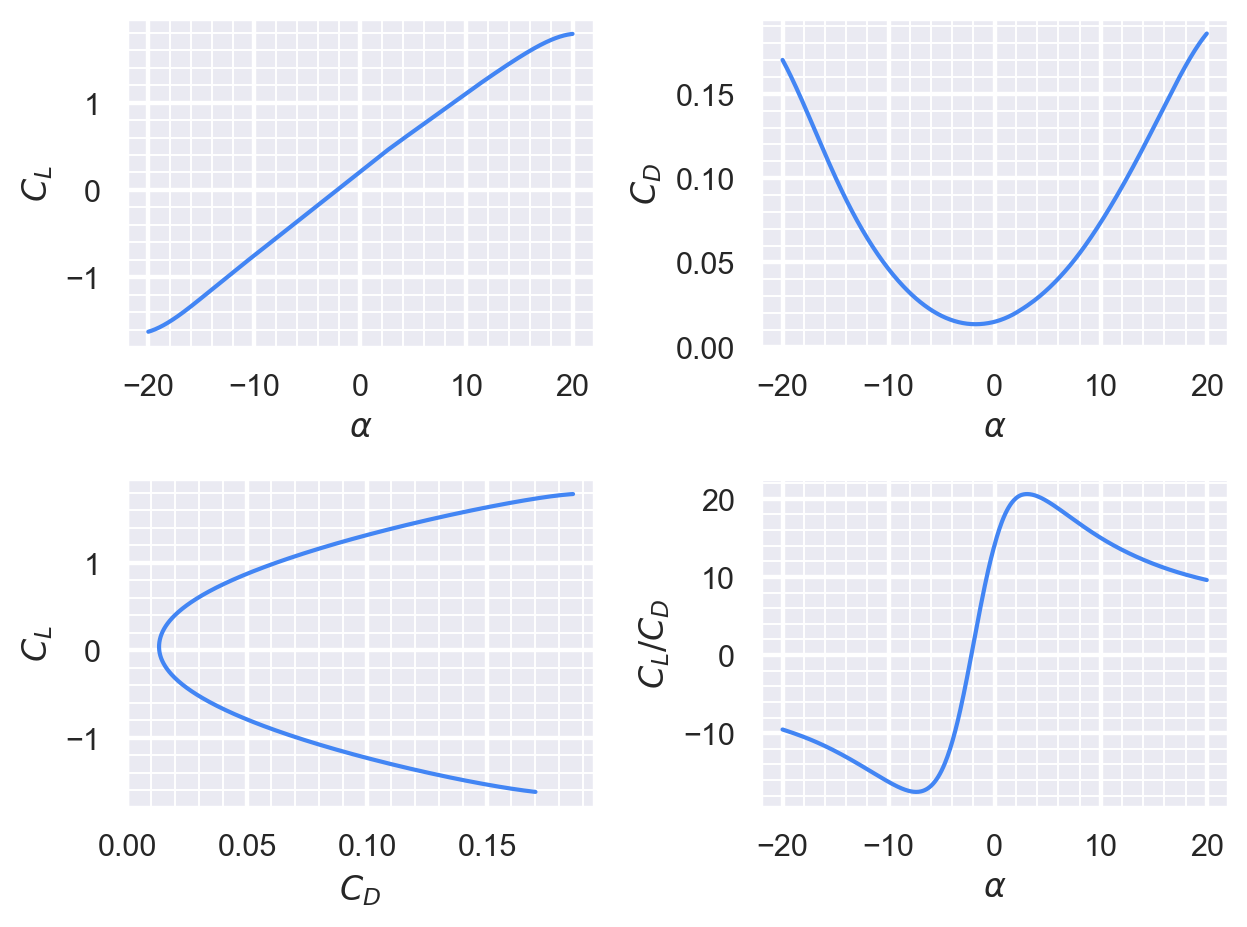

In [4]:
alpha = np.linspace(-20, 20, 500)
aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=107 * u.knot,
        alpha=alpha,
    )
).run()
# Note: AeroBuildup is fully vectorized, so we evaluate all 500 alpha points simultaneously.

import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(2, 2)
plt.sca(ax[0, 0])
plt.plot(alpha, aero["CL"])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C_L$")

plt.sca(ax[0, 1])
plt.plot(alpha, aero["CD"])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C_D$")
plt.ylim(bottom=0)

plt.sca(ax[1, 0])
plt.plot(aero["CD"], aero["CL"])
plt.xlabel(r"$C_D$")
plt.ylabel(r"$C_L$")
plt.xlim(left=0)

plt.sca(ax[1, 1])
plt.plot(alpha, aero["CL"] / aero["CD"])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C_L/C_D$")

p.show_plot()

Note: Based on the chart above, we see that the `AeroBuildup` aerodynamics engine is predicting an achievable glide ratio of:

In [5]:
print(f"AeroBuildup-predicted Glide Ratio in a Cessna 152: {np.max(aero['CL'] / aero['CD']):.2f}")

AeroBuildup-predicted Glide Ratio in a Cessna 152: 20.62


In reality, the glide ratio a 152 experiences in real engine-out flight is closer to 9 (Source: [FAA](https://www.faasafety.gov/gslac/ALC/course_content.aspx?cID=629&sID=1186&preview=true#:~:text=An%20example%20of%20this%20can,ratio%20of%20about%209%3A1.)). This discrepancy is explained by a few factors, which we describe here in roughly-descending order of importance:

* A stopped engine with a non-feathering propeller creates a lot of drag, lowering the glide ratio.
* We didn't include nose/main landing gear or the wing struts, both of which add a ton of drag.
* We didn't account for the engine intake momentum loss or oil cooler intake momentum loss, which is quite significant.
* We didn't account for sheet metal breaks, rivets, control surface gaps (hinge-line and sides)
* We didn't account for corrugation and surface imperfections on the wings, which is evident when looking at a Cessna 152 in real life.
* We didn't account for protrusions, such as the pitot tube, the stall warning vane, the antennas, navigation lights, etc.

Together, these will likely **double** the overall profile drag of the airplane (no joke! See Hoerner, "Fluid Dynamic Drag", section on complete aircraft drag buildup for more details).

There are also a few other factors that will reduce the glide ratio, but are less significant:
* The `AeroBuildup` fuselage aerodynamics models assume a relatively optimized fuselage shape, which this is not.
* We assume the wing surface is manufactured well and clean (no bug splats, rain, wear-and-tear, etc.), thereby producing an ideal laminar run.
* (Minor effect) We evaluated $L/D$ at the cruise speed of 107 kts, rather than the best-glide speed of closer to 60 kts (weight-dependent). Reynolds-number effects will change the aerodynamics, although this is minor.


### Aircraft Dynamics

Now, let's implement the dynamics for the airplane.

First, let's define some mass properties.

In [6]:
from aerosandbox.weights.mass_properties_of_shapes import mass_properties_from_radius_of_gyration

mass_props = mass_properties_from_radius_of_gyration(
    mass=1151.8 * u.lbm,
    radius_of_gyration_x=2,
    radius_of_gyration_y=3,
    radius_of_gyration_z=3,
)
mass_props.x_cg = 1


Now, we have all the pieces to implement our trajectory optimization problem.

In [7]:
### Initialize the problem
opti = asb.Opti()

### Define time. Note that the horizon length is unknown.
time_final_guess = 100
time = np.cosspace(
    0,
    opti.variable(init_guess=time_final_guess, log_transform=True),
    100
)
N = np.length(time)

time_guess = np.linspace(0, time_final_guess, N)

### Create a dynamics instance
init_state = {
    "x_e"  : 0,
    "z_e"  : -1000,  # 1 km altitude
    "speed": 107 * u.knot,
    "gamma": 0,
}

dyn = asb.DynamicsPointMass2DSpeedGamma(
    mass_props=mass_props,
    x_e=opti.variable(init_state["speed"] * time_guess),
    z_e=opti.variable(np.linspace(init_state["z_e"], 0, N)),
    speed=opti.variable(init_guess=init_state["speed"], n_vars=N),
    gamma=opti.variable(init_guess=0, n_vars=N, lower_bound=-np.pi / 2, upper_bound=np.pi / 2),
    alpha=opti.variable(init_guess=5, n_vars=N, lower_bound=-5, upper_bound=15),
)
# Constrain the initial state
for k in dyn.state.keys():
    opti.subject_to(
        dyn.state[k][0] == init_state[k]
    )

### Add in forces
dyn.add_gravity_force(g=9.81)

aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=dyn.op_point
).run()

dyn.add_force(
    *aero["F_w"],
    axes="wind"
)

### Constrain the altitude to be above ground at all times
opti.subject_to(
    dyn.altitude > 0
)

### Finalize the problem
dyn.constrain_derivatives(opti, time)  # Apply the dynamics constraints created up to this point

opti.minimize(-dyn.x_e[-1])  # Go as far downrange as you can

### Solve it
sol = opti.solve()

### Substitute the optimization variables in the dynamics instance with their solved values (in-place)
dyn = sol(dyn)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3172
Number of nonzeros in inequality constraint Jacobian.:      500
Number of nonzeros in Lagrangian Hessian.............:     1201

Total number of variables............................:      501
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      400
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:      300
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.5045556e+03 5.42e+01 1.88e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

CasADi - 2023-07-17 13:48:09 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 709, col 0).") [.../casadi/core/oracle_function.cpp:326]


  19 -3.0801665e+04 6.56e+01 5.06e+01  -0.0 1.64e+02    -  4.63e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -2.3039917e+04 2.94e+01 3.13e+01  -0.2 5.37e+01    -  9.89e-01 1.00e+00h  1
  21 -2.2969592e+04 9.03e+00 8.57e+00  -0.4 9.45e+00    -  9.71e-01 1.00e+00h  1
  22 -2.3068090e+04 1.11e+00 8.43e-01  -0.8 2.80e+00    -  9.50e-01 1.00e+00h  1
  23 -2.3064022e+04 2.25e-02 2.51e-01  -1.5 8.65e-01    -  9.81e-01 1.00e+00h  1
  24 -2.3071749e+04 8.36e-03 1.07e-01  -2.3 1.18e+00    -  1.00e+00 9.73e-01h  1
  25 -2.3072771e+04 3.92e-03 5.08e-02  -3.6 1.42e+00    -  9.58e-01 7.65e-01h  1
  26 -2.3073021e+04 1.52e-03 1.20e-02  -4.6 5.10e-01    -  1.00e+00 8.63e-01h  1
  27 -2.3073023e+04 3.74e-04 1.98e-03  -5.3 1.33e-01    -  1.00e+00 9.30e-01h  1
  28 -2.3073020e+04 6.92e-05 4.89e-04  -6.0 2.84e-02    -  1.00e+00 9.67e-01h  1
  29 -2.3073020e+04 1.40e-05 4.19e-05  -7.3 1.33e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

Let's visualize the solution.

First, we can plot it in 3D:

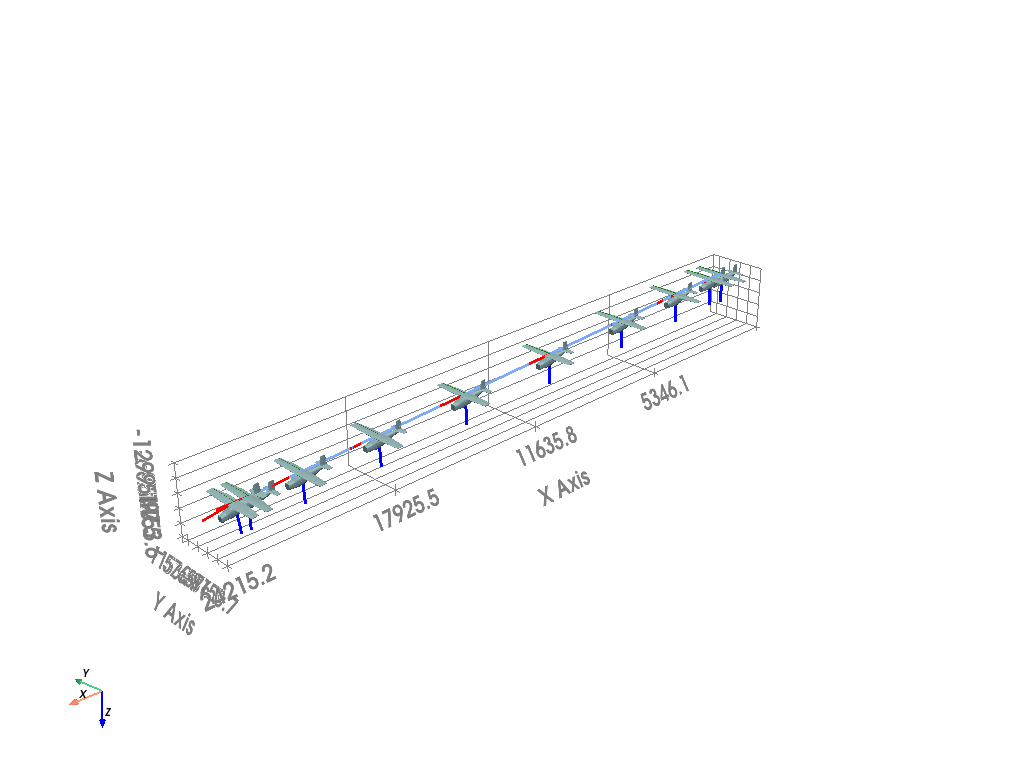

In [8]:
# NBVAL_SKIP

plotter = dyn.draw(
    vehicle_model=airplane,
    show=False
)
plotter.show(jupyter_backend="static")

Or, for a 2D-ified view:

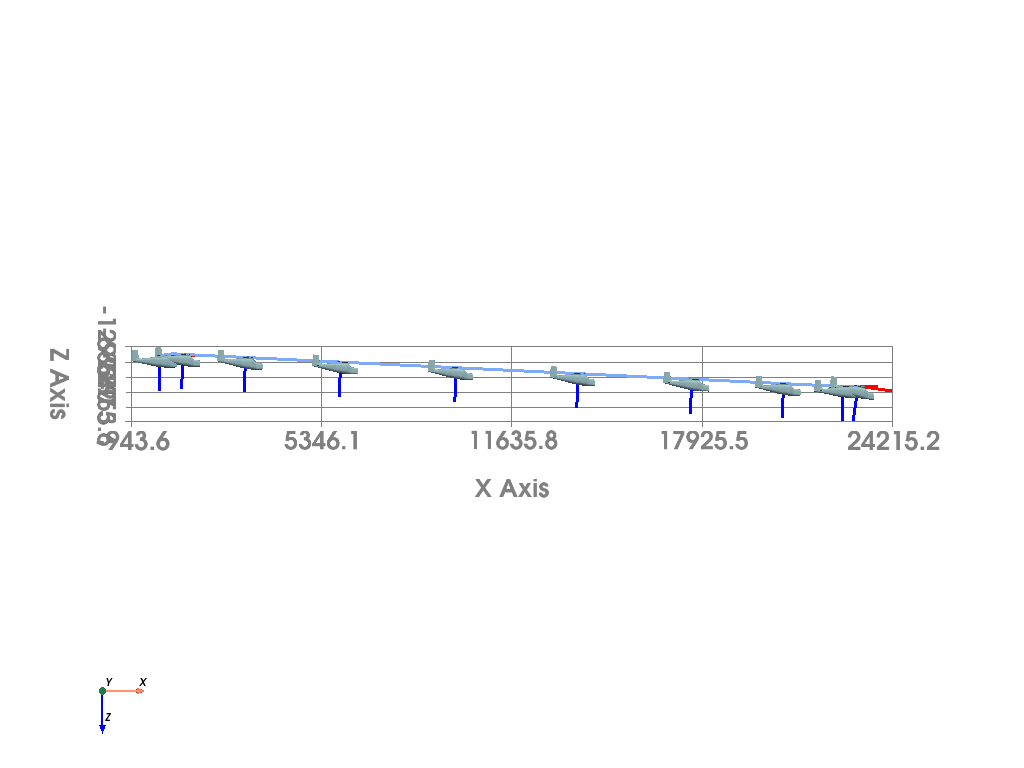

In [9]:
# NBVAL_SKIP

plotter = dyn.draw(
    vehicle_model=airplane,
    show=False
)
plotter.camera.enable_parallel_projection()
plotter.camera_position = 'xz'
plotter.camera.roll = 180
plotter.camera.azimuth = 180
plotter.show(jupyter_backend="static")

Enough pretty pictures - let's get quantitative and look more closely at some state variables:

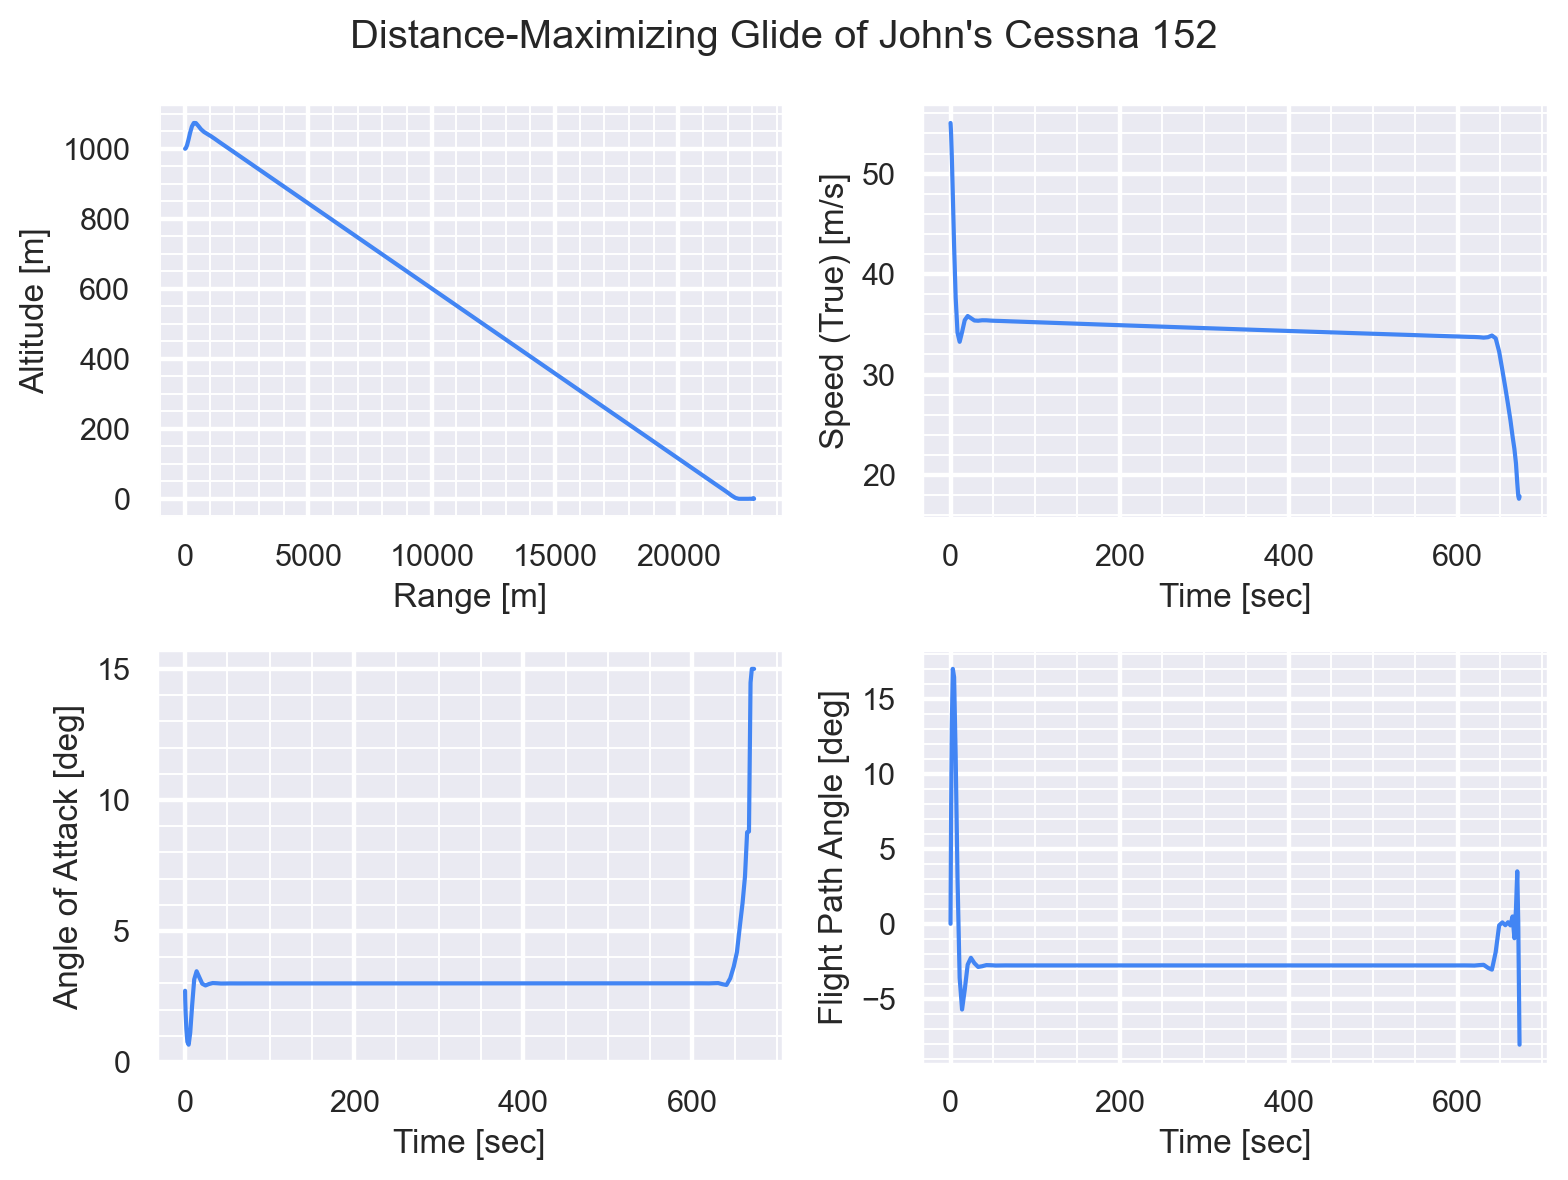

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
plt.sca(ax[0, 0])
plt.plot(dyn.x_e, dyn.altitude)
plt.xlabel("Range [m]")
plt.ylabel("Altitude [m]")

plt.sca(ax[0, 1])
plt.plot(sol.value(time), dyn.speed)
plt.xlabel("Time [sec]")
plt.ylabel("Speed (True) [m/s]")

plt.sca(ax[1, 0])
plt.plot(sol.value(time), dyn.alpha)
plt.xlabel("Time [sec]")
plt.ylabel("Angle of Attack [deg]")

plt.sca(ax[1, 1])
plt.plot(sol.value(time), np.degrees(dyn.gamma))
plt.xlabel("Time [sec]")
plt.ylabel("Flight Path Angle [deg]")

p.show_plot("Distance-Maximizing Glide of John's Cessna 152")

Okay, so what's happening here? Let's make some observations about the solution that we've found:

* The pilot, John, should immediately pull back on the stick and enter a pitch-up trajectory. Cruise speed of 107 knots (55 m/s) is far faster than best-glide speed and simply burns off energy to drag. Executing this pitch-up maneuver will convert this excess kinetic energy into excess potential energy that can extend the glide. This is consistent with pilot training: step 1 is to immediately pitch for best glide (or the slightly-different minimum-sink airspeed, depending on training and whether you're more in need of glide range or time to think).
* Once the pilot has reached the best-glide speed, they should trim to essentially maintain that speed. Note on the speed plot above that the speed slightly decreases during the glide - this is because the speed indicated here is *true* airspeed rather than *indicated* airspeed (air density is changing as we descend).
* At the end of the glide, we should put the airplane into ground effect and gradually pull back more and more on the stick (increasing alpha). This will dump speed and let us glide just a little further.
* Basically, stall it into the ground. This is probably not what you'd actually want to do in real life (you'd want to save a bit of excess energy over stall in case of unseen obstacles that you need to "hop"), but it's pretty close.

All in all, this study shows how we can maximize the glide range of an airplane using AeroSandbox dynamics engines.